<a href="https://colab.research.google.com/github/kyalan/DataScienceFactory/blob/master/20200425_boston_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load the TensorBoard notebook extension.
# %load_ext tensorboard
%matplotlib inline

import os, sys, re
import tensorflow as tf
from tensorflow.keras.datasets import boston_housing
import pandas as pd
import numpy as np
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
import sklearn.metrics
import seaborn as sns

from matplotlib import pyplot as plt

In [2]:
try:
    %tensorflow_version 2.x
except:
    pass

print(tf.__version__)

2.2.0-rc3


In [0]:
# Check GPU is avaliable
assert len(tf.config.list_physical_devices('GPU'))==1

# Import data

In [4]:
df, df_test = boston_housing.load_data(test_split=0.1, seed=9527)
X_train, X_dev, y_train, y_dev = train_test_split(df[0], df[1], test_size=0.1, random_state=9527)
df_train = (X_train, y_train)
df_dev = (X_dev, y_dev)

57344/57026 [==============================] - 0s 0us/step


In [5]:
n_train, n_dev, n_test = len(df_train[0]), len(df_dev[0]), len(df_test[0])
print('no. of data for train, dev, test', n_train, n_dev, n_test)

no. of data for train, dev, test 409 46 51


In [6]:
df_train[0].shape

(409, 13)

In [7]:
INPUT_SHAPE = df_train[0].shape[1]
LABEL_NAMES = None
N_LABELS = 1
print('INPUT_SHAPE shape:{}'.format(INPUT_SHAPE))
print('LABEL_NAMES shape:{}'.format(LABEL_NAMES))
print('N_LABELS:{}'.format(N_LABELS))

INPUT_SHAPE shape:13
LABEL_NAMES shape:None
N_LABELS:1


In [8]:
# check data structure

print('Data Sample', df_train[0][0])
print('LABEL: {}'.format(df_train[1][0]))

Data Sample [1.2269e-01 0.0000e+00 6.9100e+00 0.0000e+00 4.4800e-01 6.0690e+00
 4.0000e+01 5.7209e+00 3.0000e+00 2.3300e+02 1.7900e+01 3.8939e+02
 9.5500e+00]
LABEL: 21.2


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


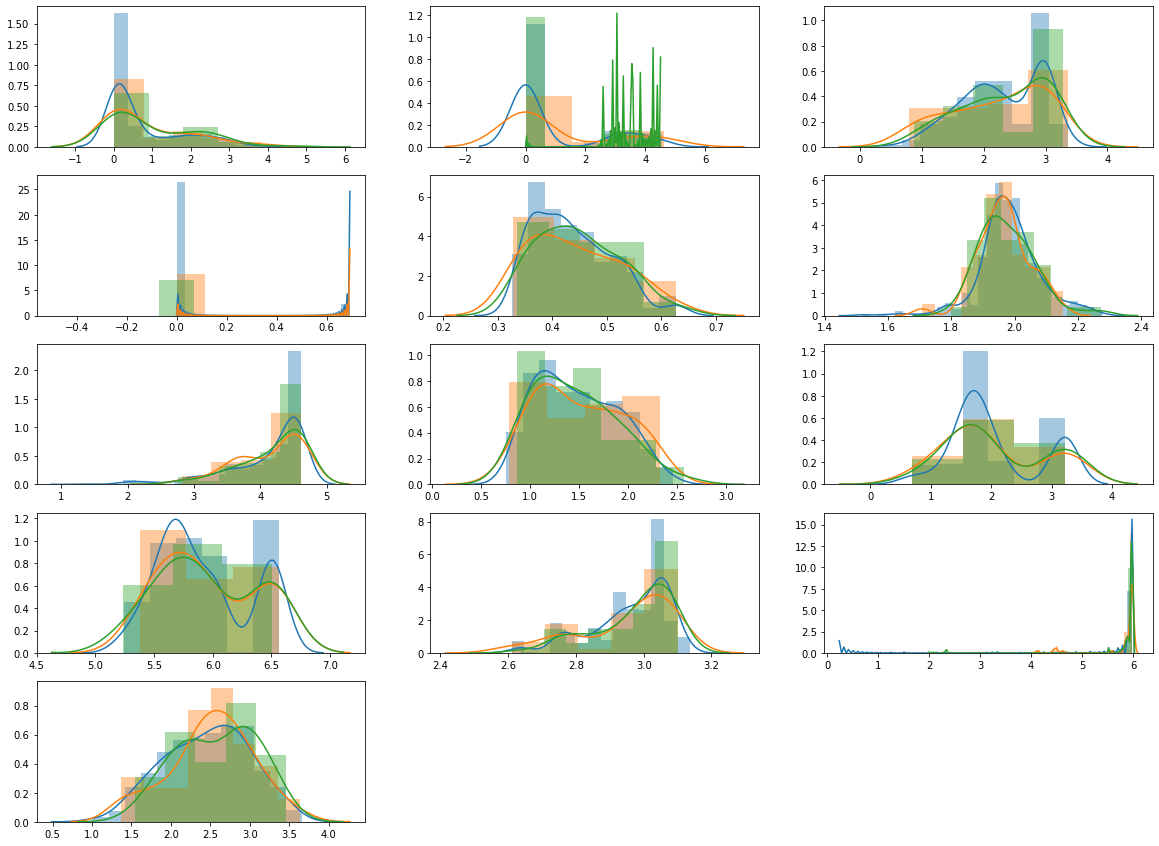

In [9]:
# features distibution on train / dev / test

fig = plt.figure(figsize=(20, 15))
for icol in range(INPUT_SHAPE):
    fig.add_subplot(np.ceil(float(INPUT_SHAPE) / 3.0).astype('int'), 3, icol + 1)
    sns.distplot(np.log1p(df_train[0][:,icol]))
    sns.distplot(np.log1p(df_dev[0][:,icol]))
    sns.distplot(np.log1p(df_test[0][:,icol]))

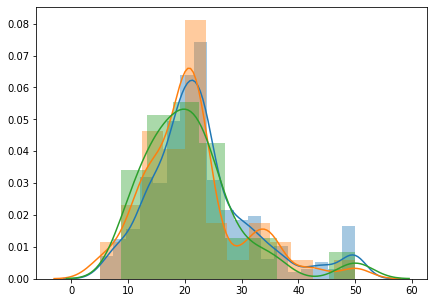

In [10]:
# features distibution on train / dev / test

fig = plt.figure(figsize=(7, 5))
sns.distplot(df_train[1])
sns.distplot(df_dev[1])
sns.distplot(df_test[1])

# Pre-processing

In [16]:
# pipeline and transformers construction

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler
pipeline = Pipeline([('pt', PowerTransformer()), ('ss', StandardScaler())])
pipeline.fit(df_train[0])

Pipeline(memory=None,
         steps=[('pt',
                 PowerTransformer(copy=True, method='yeo-johnson',
                                  standardize=True)),
                ('ss',
                 StandardScaler(copy=True, with_mean=True, with_std=True))],
         verbose=False)

In [0]:
def data_preprocessor(df):
    x_out = pipeline.transform(df[0])
    return x_out, df[1]

X_train, y_train = data_preprocessor(df_train)
X_dev, y_dev = data_preprocessor(df_dev)

# Modeling

In [0]:
def getModel():
    from tensorflow.keras import Sequential, regularizers
    from tensorflow.keras.layers import InputLayer, Lambda, Dense, Dropout
    from tensorflow.keras.optimizers import Adam

    regularizer = regularizers.l2(0.001)

    model = Sequential()
    model.add(InputLayer(13))
    model.add(Dense(13, activation='relu', kernel_regularizer=regularizer))
    model.add(Dense(N_LABELS))

    optimizer = Adam(learning_rate=0.002)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    print(model.summary())
    return model

In [0]:
# Callbacks
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# cb_earlystop = EarlyStopping(patience=10)
# cb_learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
#                                             patience=2, 
#                                             verbose=1, 
#                                             factor=0.5, 
#                                             min_lr=0.00001)

# Tensorboards callback setting
# Clear logs prior to logging data.
# !rm -rf logs

# Create log directory
# logdir = "logs/" + dt.now().strftime("%Y%m%d-%H%M%S")
# cb_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [153]:
%%time

model = getModel()

# %tensorboard --logdir logs
history = model.fit(X_train, y_train
                    , epochs=500, validation_data=(X_dev, y_dev), verbose=0
                    # , callbacks=[cb_tensorboard]
                    # , callbacks=[cb_earlystop, cb_learning_rate_reduction]
                    )

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 14        
Total params: 196
Trainable params: 196
Non-trainable params: 0
_________________________________________________________________
None
CPU times: user 26.9 s, sys: 2.98 s, total: 29.9 s
Wall time: 21.2 s


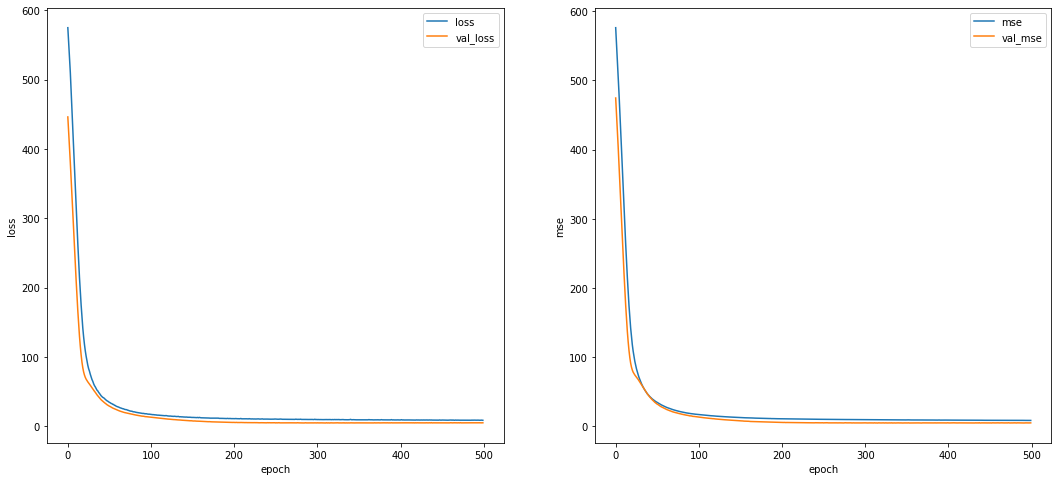

In [149]:
def plot_history(history):
    hist = history.history
    keys = [x for x in history.history if re.search('^[A-Za-z]+$', x)]

    fig = plt.figure(figsize=(18, 8))
    iplot = 0
    for key in keys:
        iplot += 1
        fig.add_subplot(1, 2, iplot)
        plt.xlabel('epoch')
        plt.ylabel(key)
        plt.plot(range(len(hist[key])), hist[key], label = key)
        plt.plot(range(len(hist['val_' + key])), hist['val_' + key], label = 'val_' + key)
        plt.legend()
    plt.show()

plot_history(history)

# Model Evaluation

In [154]:
X_test, y_test = data_preprocessor(df_test)

eval = model.evaluate(X_test, y_test)
print('Test data: Loss = {}, MSE = {}'.format(eval[0], eval[1]))

2/2 [==============================] - 0s 1ms/step - loss: 8.0222 - mse: 7.5694
Test data: Loss = 8.022173881530762, MSE = 7.569425106048584


In [155]:
%%time

test_labels = np.array(y_test)
test_pred = model.predict(X_test).flatten()

print('MSE = {}'.format(np.mean((test_labels - test_pred)**2)))

MSE = 7.5694249275198064
CPU times: user 54 ms, sys: 1.41 ms, total: 55.4 ms
Wall time: 53.6 ms


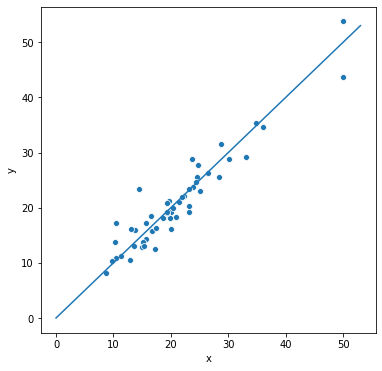

In [156]:
fig = plt.figure(figsize=(6, 6))
sns.scatterplot(x='real', y='pred', data=pd.DataFrame({'real':test_labels, 'pred':test_pred}))
sns.lineplot(x='x', y='y', data=pd.DataFrame({'x':np.arange(np.amax([test_labels, test_pred])), 'y':np.arange(np.amax([test_labels, test_pred]))}))